In [4]:
# download the dataset
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2020-08-08 11:04:02--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.76.198
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.76.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  6.34MB/s    in 2.0s    

2020-08-08 11:04:05 (6.34 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13568290/13568290]



In [5]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: jena_climate_2009_2016.csv  


In [6]:
# import needed libraries
import tensorflow as tf
from keras import layers, optimizers, losses, models

from sklearn.preprocessing import StandardScaler


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

In [7]:
dataset = pd.read_csv('jena_climate_2009_2016.csv')
dataset.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


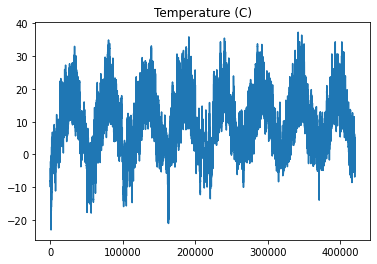

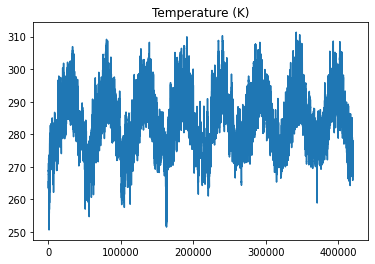

In [8]:
plt.title('Temperature (C)')
plt.plot(dataset['T (degC)'])
plt.show()
plt.title('Temperature (K)')
plt.plot(dataset['Tpot (K)'])
plt.show()

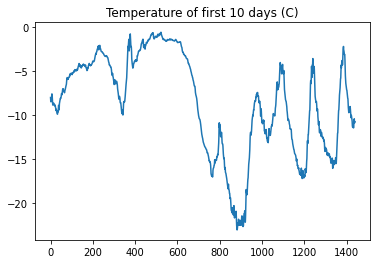

In [9]:
# let's plot the first 10 day's temperature
# the data is collected every 10 minutes. 
# so 10 day would make 6*24*10 = 1440
plt.title('Temperature of first 10 days (C)')
plt.plot(dataset['T (degC)'][:1440])
plt.show()

In [10]:
# Now by looking 720 timesteps, can we predict the temperature in 144 timesteps?
# 720 = 6*24*5 # look 5 day before
# 144 = 6*24 # predict next day

# now since the dataset is numerical, 
# we can just apply standardization then proceed to next step
scaler = StandardScaler()
# we should apply the standardization based on training data
# I will use 200k timesteps as a training data
# also we don't need to keep the date-time column
# since it doesn't have an effect on the prediction
train_ds = dataset.iloc[:200000, 1:]
test_ds = dataset.iloc[200000:, 1:]

# fit and transform the training data
train_ds = scaler.fit_transform(train_ds)
# since we already fitted the scaler to training data
# we already have mean and std of training
# so all we need to do is transform test data
test_ds = scaler.transform(test_ds)

In [11]:
def data_gen(data, lookback, delay, shuffle = True,
             batch_size = 128, step = 6):
  max_index = len(data) - delay - 1
  i = lookback + 1
  while 1:
    if shuffle:
      rows = np.random.randint(lookback, max_index, size = batch_size)
    else:
      if i + batch_size >= max_index:
        i = lookback + 1
      rows = np.arange(i, min(i + batch_size, max_index))
      i += batch_size
    samples = np.zeros((len(rows),
                       lookback // step,
                       data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets


In [12]:
lookback = 1440
step = 6
delay = 144
batch_size = 128


train_gen = data_gen(train_ds, 
                     lookback = lookback,
                     delay = delay,
                     shuffle = True,
                     batch_size = batch_size,
                     step = step)

test_gen = data_gen(test_ds[100000:], 
                     lookback = lookback,
                     delay = delay,
                     batch_size = batch_size,
                     step = step)

val_gen = data_gen(test_ds[:100000], 
                     lookback = lookback,
                     delay = delay,
                     batch_size = batch_size,
                     step = step)


val_steps = 100000 - lookback
test_steps = len(test_ds[:100000]) - lookback

In [ ]:
# Now let's create some baselines from starting with simple 
# non-ML approaches
# to basic ML approaches

# One approach would be
# expecting temperature 24 hours later would be same as now
# we'll evaluate this approach by using MAE (Mean Absolute Error)
def MAE(preds, targets):
  return np.mean(np.abs(preds-targets))

def evaluate_nonml():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = MAE(preds, targets)
    batch_maes.append(mae)
  return np.mean(batch_maes)
# nonml_mae = evaluate_nonml() # avg mae: 0.289861
# print(nonml_mae)
# I have evaluated once but it took so long so 
# I'll keep the evaluation score manually
# also this score is for normalized temperature
# so we need to multiply it by std of temperature 
# to find the correct error score
nonml_approach = 0.289861 * dataset['T (degC)'][:200000].std()
print('NonML Temperature (degC) (MAE): %d'% nonml_approach, '| MAE:%f' % 0.289861)

NonML Temperature (degC) (MAE): 2 | MAE:0.289861


Epoch 1/20
500/500 [==============================] - 55s 110ms/step - loss: 1.6373 - val_loss: 0.8377
Epoch 2/20
500/500 [==============================] - 51s 102ms/step - loss: 0.6665 - val_loss: 0.4733
Epoch 3/20
500/500 [==============================] - 51s 102ms/step - loss: 0.3685 - val_loss: 0.3208
Epoch 4/20
500/500 [==============================] - 51s 102ms/step - loss: 0.2871 - val_loss: 0.3480
Epoch 5/20
500/500 [==============================] - 51s 101ms/step - loss: 0.2643 - val_loss: 0.3209
Epoch 6/20
500/500 [==============================] - 50s 100ms/step - loss: 0.2511 - val_loss: 0.3044
Epoch 7/20
500/500 [==============================] - 50s 100ms/step - loss: 0.2413 - val_loss: 0.3049
Epoch 8/20
500/500 [==============================] - 50s 101ms/step - loss: 0.2350 - val_loss: 0.3811
Epoch 9/20
500/500 [==============================] - 50s 99ms/step - loss: 0.2311 - val_loss: 0.3244
Epoch 10/20
500/500 [==============================] - 50s 101ms/step - lo

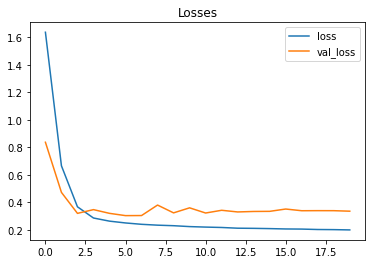

In [ ]:
# This kind of baseline isn't useful. The better way to 
# create a baseline is using simple and cheap models 
# to evaluate. Now I'll use simple dense-based model as a baseline
baseline = models.Sequential([
  # data shape is specified in data_gen function
  # flattening the data will remove the notion of time
  layers.Flatten(input_shape = (lookback // step, train_ds.shape[-1])),
  layers.Dense(32, activation = 'relu'),
  layers.Dense(1) # we don't need to specify any activation function
])
baseline.compile(optimizer = optimizers.RMSprop(), loss = 'mae')
r = baseline.fit(train_gen, steps_per_epoch = 500,
              epochs = 20,
              validation_data = val_gen,
              validation_steps = val_steps // 20) 

plt.title('Losses')
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

In [ ]:
# now we can find the correct error in celcius degrees
recurrent_mae = 0.3366 * dataset['T (degC)'][:200000].std()
print('Error in Celcius degrees: %f | MAE: %f' % (recurrent_mae, 0.3366))

Error in Celcius degrees: 2.979759 | MAE: 0.336600


Epoch 1/20
500/500 [==============================] - 218s 435ms/step - loss: 0.3052 - val_loss: 0.2734
Epoch 2/20
500/500 [==============================] - 220s 440ms/step - loss: 0.2845 - val_loss: 0.2627
Epoch 3/20
500/500 [==============================] - 229s 458ms/step - loss: 0.2757 - val_loss: 0.2629
Epoch 4/20
500/500 [==============================] - 217s 435ms/step - loss: 0.2706 - val_loss: 0.2747
Epoch 5/20
500/500 [==============================] - 216s 432ms/step - loss: 0.2648 - val_loss: 0.2653
Epoch 6/20
500/500 [==============================] - 219s 439ms/step - loss: 0.2602 - val_loss: 0.2767
Epoch 7/20
500/500 [==============================] - 222s 444ms/step - loss: 0.2564 - val_loss: 0.2758
Epoch 8/20
500/500 [==============================] - 220s 439ms/step - loss: 0.2521 - val_loss: 0.2765
Epoch 9/20
500/500 [==============================] - 222s 444ms/step - loss: 0.2466 - val_loss: 0.2728
Epoch 10/20
500/500 [==============================] - 225s 449m

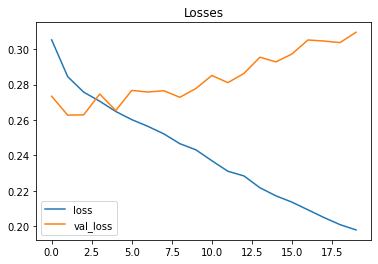

In [ ]:
# this simple baseline couldn't outperform the first one
# now we'll create a simple recurrent baseline and look at
# the data as a sequence

# I almost use LSTM everytime. But in this baseline 
# I'll use GRU (Gated recurrent unit)
# GRU is somewhat streamlined and cheaper than lstm
# which makes it preferable for creating a baseline
recurrent_baseline = models.Sequential([
  layers.GRU(32, input_shape = (None, train_ds.shape[-1])),
  layers.Dense(1)
])
recurrent_baseline.compile(optimizer = optimizers.RMSprop(),
                           loss = 'mae')
r = recurrent_baseline.fit(train_gen, 
                           epochs = 20,
                           steps_per_epoch = 500,
                           validation_data = val_gen,
                           validation_steps = val_steps // 20)
print(r.history['loss'][-1], r.history['val_loss'][-1])
plt.title('Losses')
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

In [28]:
# now we can find the correct error in celcius degrees
recurrent_mae = 0.30955278873443604 * dataset['T (degC)'][:200000].std()
print('Error in Celcius degrees: %f | MAE: %f' % (recurrent_mae, 0.30955278873443604))

Error in Celcius degrees: 2.740323 | MAE: 0.309553


Epoch 1/40
500/500 [==============================] - 208s 416ms/step - loss: 0.3280 - val_loss: 0.2784
Epoch 2/40
500/500 [==============================] - 212s 423ms/step - loss: 0.3056 - val_loss: 0.2801
Epoch 3/40
500/500 [==============================] - 213s 426ms/step - loss: 0.2987 - val_loss: 0.2682
Epoch 4/40
500/500 [==============================] - 214s 428ms/step - loss: 0.2925 - val_loss: 0.2774
Epoch 5/40
500/500 [==============================] - 214s 427ms/step - loss: 0.2888 - val_loss: 0.2730
Epoch 6/40
500/500 [==============================] - 221s 442ms/step - loss: 0.2855 - val_loss: 0.2686
Epoch 7/40
500/500 [==============================] - 215s 430ms/step - loss: 0.2826 - val_loss: 0.2679
Epoch 8/40
500/500 [==============================] - 219s 437ms/step - loss: 0.2796 - val_loss: 0.2704
Epoch 9/40
500/500 [==============================] - 218s 436ms/step - loss: 0.2777 - val_loss: 0.2674
Epoch 10/40
500/500 [==============================] - 218s 435m

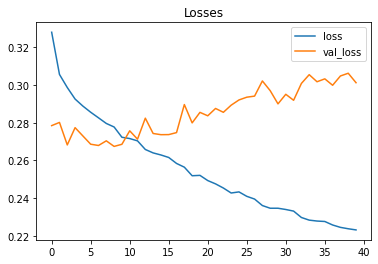

In [ ]:
# Let's apply recurrent dropout to reduce the error rate
rnn_gru_dropout = models.Sequential([
  layers.GRU(32, dropout = .2, recurrent_dropout = .2,
             input_shape = (None, train_ds.shape[-1])),
  layers.Dense(1)
])

rnn_gru_dropout.compile(optimizer = optimizers.RMSprop(),
                        loss = 'mae')

r = rnn_gru_dropout.fit(train_gen,
                        steps_per_epoch = 500,
                        epochs = 40,
                        validation_steps = val_steps // 40, 
                        validation_data = val_gen)

print(r.history['loss'][-1], r.history['val_loss'][-1])
plt.title('Losses')
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

In [27]:
# now we can find the correct error in celcius degrees
recurrent_mae = 0.3011966347694397 * dataset['T (degC)'][:200000].std()
print('Error in Celcius degrees: %f | MAE: %f' % (recurrent_mae, 0.3011966347694397))

Error in Celcius degrees: 2.666350 | MAE: 0.301197


In [ ]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',dropout=0.1,recurrent_dropout=0.5))
model.add(layers.Dense(1))model.compile(optimizer=RMSprop(), loss='mae')

Epoch 1/40
500/500 [==============================] - 567s 1s/step - loss: 0.3222 - val_loss: 0.2859
Epoch 2/40
500/500 [==============================] - 566s 1s/step - loss: 0.3018 - val_loss: 0.2689
Epoch 3/40
500/500 [==============================] - 567s 1s/step - loss: 0.2928 - val_loss: 0.2706
Epoch 4/40
500/500 [==============================] - 594s 1s/step - loss: 0.2863 - val_loss: 0.2653
Epoch 5/40
500/500 [==============================] - 610s 1s/step - loss: 0.2808 - val_loss: 0.2759
Epoch 6/40
500/500 [==============================] - 610s 1s/step - loss: 0.2750 - val_loss: 0.2689
Epoch 7/40
500/500 [==============================] - 600s 1s/step - loss: 0.2686 - val_loss: 0.2740
Epoch 8/40
500/500 [==============================] - 596s 1s/step - loss: 0.2647 - val_loss: 0.2896
Epoch 9/40
500/500 [==============================] - 599s 1s/step - loss: 0.2601 - val_loss: 0.2834
Epoch 10/40
500/500 [==============================] - 588s 1s/step - loss: 0.2558 - val_lo

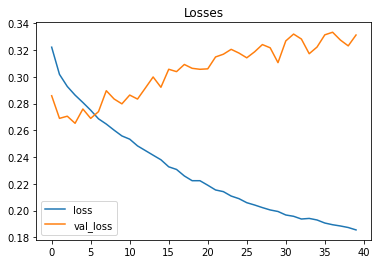

In [ ]:
r = stacked_recurrent_baseline.fit(train_gen,
                                  steps_per_epoch = 500, 
                                  epochs = 40,
                                  validation_steps = val_steps // 40, 
                                  validation_data = val_gen)

print(r.history['loss'][-1], r.history['val_loss'][-1])
plt.title('Losses')
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

In [ ]:
# now we can find the correct error in celcius degrees
recurrent_mae = 0.2653 * dataset['T (degC)'][:200000].std()
print('Error in Celcius degrees: %f | MAE: %f' % (recurrent_mae, r.history['val_loss'][-1]))

Error in Celcius degrees: 2.348574 | MAE: 0.331290


Epoch 1/40
500/500 [==============================] - 111s 222ms/step - loss: 0.2961 - val_loss: 0.2766
Epoch 2/40
500/500 [==============================] - 111s 221ms/step - loss: 0.2742 - val_loss: 0.2647
Epoch 3/40
500/500 [==============================] - 110s 220ms/step - loss: 0.2672 - val_loss: 0.2689
Epoch 4/40
500/500 [==============================] - 110s 219ms/step - loss: 0.2609 - val_loss: 0.2585
Epoch 5/40
500/500 [==============================] - 110s 220ms/step - loss: 0.2565 - val_loss: 0.2701
Epoch 6/40
500/500 [==============================] - 110s 220ms/step - loss: 0.2516 - val_loss: 0.2670
Epoch 7/40
500/500 [==============================] - 110s 219ms/step - loss: 0.2441 - val_loss: 0.2671
Epoch 8/40
500/500 [==============================] - 110s 220ms/step - loss: 0.2369 - val_loss: 0.2746
Epoch 9/40
500/500 [==============================] - 110s 219ms/step - loss: 0.2316 - val_loss: 0.2872
Epoch 10/40
500/500 [==============================] - 110s 220m

[]

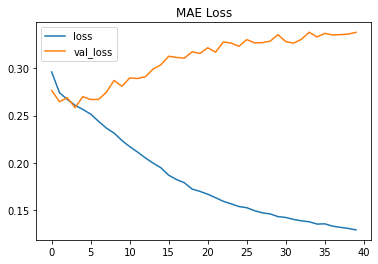

In [14]:
# Using bidirectional RNNs:
# Bidirectional RNNs are using 2 RNNs to learn representations in two ways: chronologically and antichronologically.
# Then they merge their representations of data to exploit the importance of order in sequence data 

bidirectional_rnn = models.Sequential([
  layers.Bidirectional(layers.GRU(32), input_shape = (None, train_ds.shape[-1])),
  layers.Dense(1)
])
bidirectional_rnn.compile(optimizer = optimizers.RMSprop(),
                          loss = 'mae')

r = bidirectional_rnn.fit(train_gen,
                          validation_data = val_gen,
                          steps_per_epoch = 500,
                          validation_steps = val_steps // 40,
                          epochs = 40)

plt.title('MAE Loss')
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.plot()

In [15]:
# now we can find the correct error in celcius degrees
recurrent_mae = 0.2585 * dataset['T (degC)'][:200000].std()
print('Error in Celcius degrees: %f | MAE: %f' % (recurrent_mae, 0.2585))

Error in Celcius degrees: 2.288377 | MAE: 0.258500


Epoch 1/40
500/500 [==============================] - 111s 221ms/step - loss: 0.2966 - val_loss: 0.2787
Epoch 2/40
500/500 [==============================] - 110s 220ms/step - loss: 0.2638 - val_loss: 0.2746
Epoch 3/40
500/500 [==============================] - 110s 220ms/step - loss: 0.2479 - val_loss: 0.2873
Epoch 4/40
500/500 [==============================] - 110s 220ms/step - loss: 0.2348 - val_loss: 0.2981
Epoch 5/40
500/500 [==============================] - 110s 220ms/step - loss: 0.2225 - val_loss: 0.3070
Epoch 6/40
500/500 [==============================] - 110s 221ms/step - loss: 0.2119 - val_loss: 0.3094
Epoch 7/40
500/500 [==============================] - 110s 220ms/step - loss: 0.2020 - val_loss: 0.3153
Epoch 8/40
500/500 [==============================] - 110s 220ms/step - loss: 0.1948 - val_loss: 0.3240
Epoch 9/40
500/500 [==============================] - 110s 220ms/step - loss: 0.1874 - val_loss: 0.3277
Epoch 10/40
500/500 [==============================] - 110s 221m

[]

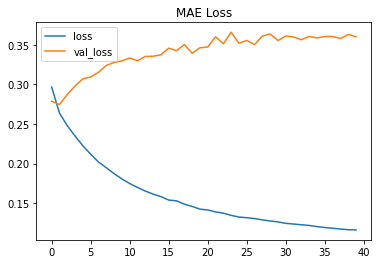

In [19]:
# Using the architecture above with LSTM

bidirectional_lstm = models.Sequential([
  layers.Bidirectional(layers.LSTM(32), input_shape = (None, train_ds.shape[-1])),
  layers.Dense(1)
])
bidirectional_lstm.compile(optimizer = optimizers.RMSprop(),
                          loss = 'mae')

r = bidirectional_lstm.fit(train_gen,
                          validation_data = val_gen,
                          steps_per_epoch = 500,
                          validation_steps = val_steps // 40,
                          epochs = 40)

plt.title('MAE Loss')
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.plot()